<a href="https://colab.research.google.com/github/JackRich1/NV-cavity-QED/blob/main/Parameter_Update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
# Constants (defined as PyTorch tensors)
h = torch.tensor(6.626e-34, dtype=torch.float32, requires_grad=False)  # Planck constant (J·s)
mu_B = torch.tensor(9.274009994e-24, dtype=torch.float32, requires_grad=False)  # Bohr magneton (J/T)
g_e = torch.tensor(2.00231930436256, dtype=torch.float32, requires_grad=False)  # Electron g-factor

kc0 = torch.tensor(130e3, dtype=torch.float32, requires_grad=False)    # Cavity linewidth (Hz)
kc1 = torch.tensor(130e3, dtype=torch.float32, requires_grad=False)    # Cavity loop coupling (Hz)
k = torch.tensor(260e3, dtype=torch.float32, requires_grad=False)      # Total cavity decay rate (Hz)
gammao = torch.tensor(2.23e3, dtype=torch.float32, requires_grad=False)  # Optical polarization rate (Hz)
rho = torch.tensor(4.0, dtype=torch.float32, requires_grad=False)          # NV density (unitless)
Vd = torch.tensor(3e-3 * 3e-3 * 0.9e-3, dtype=torch.float32, requires_grad=False)  # Diamond volume (m^3)
Gamma = torch.tensor(330e3 / 4 * rho.item(), dtype=torch.float32, requires_grad=False)     # Inhomogeneous linewidth (Hz)
gamma_th = torch.tensor(90.0, dtype=torch.float32, requires_grad=False)  # Thermal relaxation rate (Hz)

# Make sure to use tensor operations for the computation of I
I = 1.225 * gammao - 4.809 * gamma_th + 3.085 * torch.sqrt(
    0.1577 * gammao ** 2 - 0.5229 * gammao * gamma_th + gamma_th ** 2)

Polarization = (0.29 * I) / (3 * gamma_th + 0.38 * I)
N = (rho * 3.51 / 12.01 * 6.022e23) * Vd  # Number of NV centers

# Base resonance frequency
base_frequency = torch.tensor(2.87e9, dtype=torch.float32, requires_grad=False)

# True system parameters
gamma_true = 55e3
gs_true = 0.019

# Simulate a dataset of B field values (constant with noise)
B_field_true = 1e-5  # 0.01 mT
num_total_samples = 500
noise_level = 1e-6  # noise
B_fields_total = B_field_true + np.random.normal(0, noise_level, num_total_samples)

# Select 30 evenly spaced indices
num_samples = 10
indices = np.linspace(0, num_total_samples - 1, num_samples, dtype=int)
B_fields = B_fields_total[indices]

# Convert to torch tensor
B_tensor = torch.tensor(B_fields, dtype=torch.float32)

# Compute spin_freq_true from B_fields
delta_f_true = g_e * mu_B * B_tensor / h  # Shape: (num_samples,)
spin_freq_true = base_frequency + delta_f_true  # Shape: (num_samples,)

# --- Differentiable simulate_r2 function ---
def simulate_r2_torch(frequency, spin_freq, gamma, gs):
    # All inputs are PyTorch tensors
    energy_d = h * frequency  # h * omega
    Delta = spin_freq - frequency  # Detuning
    g = torch.sqrt(N * Polarization) * gs * 0.16
    alpha2 = 10 ** (-18 / 10) * 1e-3 / (energy_d * kc1 * 2 * np.pi) * (0.53 ** 2)
    beta2 = alpha2 * kc1
    chi_0 = torch.sqrt(1 + 8 * (gamma / gammao) * (gs ** 2) * alpha2 / (gamma ** 2))
    Gamma_1_0 = Gamma + chi_0 * gamma
    geff_0 = g / chi_0
    denom = (Delta - (g ** 2) * Delta / ((Gamma_1_0 / 2) ** 2 + Delta ** 2)) ** 2 + \
            (k / 2 + (geff_0 ** 2) * (Gamma_1_0 / 2) / ((Gamma_1_0 / 2) ** 2 + Delta ** 2)) ** 2
    term1 = kc1 * beta2
    alpha2_1 = term1 / denom
    r2 = (-1 + torch.sqrt(kc1 * alpha2_1 / beta2 + 1e-12)) ** 2  # Add small value to prevent sqrt of zero
    return r2

# Simulate the observed r2 measurements for each B field value at a given frequency
def simulate_r2_numpy(frequency, spin_freq, gamma, gs):
    h_np = 6.626e-34
    energy_d = h_np * frequency   # h * omega
    Delta = spin_freq - frequency  # Detuning of microwave drive from resonance
    g = np.sqrt(N.item() * Polarization.item()) * gs * 0.16  # Collective coupling strength
    alpha2 = 10 ** (-18 / 10) * 1e-3 / (energy_d * kc1.item() * 2 * np.pi) * (0.53 ** 2)
    beta2 = alpha2 * kc1.item()
    chi_0 = np.sqrt(1 + 8 * (gamma / gammao.item()) * (gs ** 2) * alpha2 / (gamma ** 2))
    Gamma_1_0 = Gamma.item() + chi_0 * gamma
    geff_0 = g / chi_0
    denom = (Delta - (g ** 2) * Delta / ((Gamma_1_0 / 2) ** 2 + Delta ** 2)) ** 2 + \
            (k.item() / 2 + (geff_0 ** 2) * (Gamma_1_0 / 2) / ((Gamma_1_0 / 2) ** 2 + Delta ** 2)) ** 2
    term1 = kc1.item() * beta2
    alpha2_1 = term1 / denom
    r2 = (-1 + np.sqrt(kc1.item() * alpha2_1 / beta2 + 1e-12)) ** 2
    return r2

In [ ]:
# --- Model Definition ---
class NVMagnetometerModel(nn.Module):
    def __init__(self):
        super(NVMagnetometerModel, self).__init__()
        # Learnable parameters
        self.gamma = nn.Parameter(torch.tensor(70e3, dtype=torch.float32, requires_grad=True))
        self.gs = nn.Parameter(torch.tensor(0.01, dtype=torch.float32, requires_grad=True))

# Initialize the model
model = NVMagnetometerModel()

# Optimizer for gamma and gs
optimizer_params = optim.Adam([
    {'params': [model.gamma], 'lr': 1000},  # Learning rate for gamma
    {'params': [model.gs], 'lr': 2e-4}      # Learning rate for gs
])

num_epochs = 20
num_steps = 10  # Number of gradient steps for frequency at each time step
delta_freq = 5e5   # Small frequency shift for gradient estimation
frequency_lr = 5e11  # Learning rate for frequency update

In [ ]:
# Lists to store parameter estimates over epochs
gamma_estimates_over_epochs = [model.gamma.item()]
gs_estimates_over_epochs = [model.gs.item()]
B_estimates_over_epochs = [0.0]


latest_B_estimate = 0.0

initial_freq = base_frequency + torch.tensor(np.random.uniform(-0.5e6, 0.5e6), dtype=torch.float32, requires_grad=True)

epoch0 = []

for epoch in range(num_epochs):

    # Initialize frequency to some value near base frequency
    frequency = initial_freq
    measurements = []

    # Set what we estimate is the true spin transition frequency for simulation of r2
    B_estimate_tensor = torch.tensor(B_estimates_over_epochs[-1], dtype=torch.float32, requires_grad=False)
    sim_spin_freq = base_frequency + B_estimate_tensor * (g_e * mu_B) / h


    for i in range(len(B_tensor)):
        # Get the true B field and spin frequency
        B_true = B_tensor[i]
        spin_freq = spin_freq_true[i]

        # Measure r2_measured at current frequency
        r2_measured_current = simulate_r2_numpy(frequency.item(), spin_freq.item(), gamma_true, gs_true)
        if epoch==0: epoch0.append([frequency.item(),r2_measured_current])
        r2_measured_current = torch.tensor(r2_measured_current, dtype=torch.float32)
        measurements.append([frequency.item(),r2_measured_current])

        # Measure r2_measured at frequency + delta_freq
        frequency_shifted = frequency + delta_freq * np.exp(-i/num_steps)
        r2_measured_shifted = simulate_r2_numpy(frequency_shifted.item(), spin_freq.item(), gamma_true, gs_true)
        if epoch==0: epoch0.append([frequency_shifted.item(),r2_measured_shifted])
        r2_measured_shifted = torch.tensor(r2_measured_shifted, dtype=torch.float32)
        measurements.append([frequency_shifted.item(),r2_measured_shifted])

        # Simulate r2_simulated at current frequency using model parameters
        # r2_simulated = simulate_r2_torch(frequency, sim_spin_freq, model.gamma, model.gs)
        r2_simulated = simulate_r2_torch(frequency, spin_freq.item(), model.gamma, model.gs)

        # Compute gradient of r2_measured w.r.t. frequency
        gradient = (r2_measured_shifted - r2_measured_current) / delta_freq

        # Update frequency to reduce r2_measured
        with torch.no_grad():
            frequency -= frequency_lr * gradient

        # Ensure frequency requires grad for the next iteration
        # frequency.requires_grad = True

        # Compute loss
        loss = (r2_simulated - r2_measured_current) ** 2

        # Zero gradients
        optimizer_params.zero_grad()

        # Backpropagate loss and update parameters
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer_params.step()

        # Store frequency and B_estimated
        delta_f_estimated = frequency - base_frequency
        B_estimated = delta_f_estimated * h / (g_e * mu_B)
        latest_B_estimate = B_estimated

    # Store the final gamma and gs after the epoch
    gamma_estimates_over_epochs.append(model.gamma.item())
    gs_estimates_over_epochs.append(model.gs.item())

    # Store latest B estimate for the epoch

    # Method 1: find frequency of minimum r2
    # frequencies = [pair[0] for pair in epoch0]
    # r2_values = [pair[1] for pair in epoch0]
    # min_r2_index = r2_values.index(min(r2_values))
    # min_r2_frequency = frequencies[min_r2_index]
    # delta_f_estimated = min_r2_frequency - base_frequency
    # B_estimated = delta_f_estimated * h / (g_e * mu_B)
    # B_estimates_over_epochs.append(B_estimated.item())

    # Method 2: find midpoint of frequencies with r2 < 0.01
    frequencies = [pair[0] for pair in epoch0]
    r2_values = [pair[1] for pair in epoch0]
    filtered_frequencies = [frequencies[i] for i in range(len(r2_values)) if r2_values[i] < 0.01]
    if filtered_frequencies:
        min_r2_frequency = (min(filtered_frequencies) + max(filtered_frequencies)) / 2
    else:
        min_r2_index = r2_values.index(min(r2_values))
        min_r2_frequency = frequencies[min_r2_index]
    delta_f_estimated = min_r2_frequency - base_frequency
    B_estimated = delta_f_estimated * h / (g_e * mu_B)
    B_estimates_over_epochs.append(B_estimated.item())

    # Method 3: Use the last frequency from gradient descent
    # B_estimates_over_epochs.append(latest_B_estimate.item())

    # Print statistics
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Estimated gamma: {gamma_estimates_over_epochs[-1]:.2f} Hz")
    print(f"Estimated gs: {gs_estimates_over_epochs[-1]:.5f}")
    print(f"Estimated B field: {latest_B_estimate*1e3:.5f} mT")


Epoch 1/20
Estimated gamma: 68132.95 Hz
Estimated gs: 0.01159
Estimated B field: 0.00691 mT
Epoch 2/20
Estimated gamma: 65871.44 Hz
Estimated gs: 0.01299
Estimated B field: 0.00691 mT
Epoch 3/20
Estimated gamma: 63478.71 Hz
Estimated gs: 0.01430
Estimated B field: 0.00691 mT
Epoch 4/20
Estimated gamma: 61067.19 Hz
Estimated gs: 0.01550
Estimated B field: 0.00691 mT
Epoch 5/20
Estimated gamma: 58775.04 Hz
Estimated gs: 0.01654
Estimated B field: 0.00691 mT
Epoch 6/20
Estimated gamma: 56756.60 Hz
Estimated gs: 0.01739
Estimated B field: 0.00691 mT
Epoch 7/20
Estimated gamma: 55147.57 Hz
Estimated gs: 0.01803
Estimated B field: 0.00691 mT
Epoch 8/20
Estimated gamma: 54021.41 Hz
Estimated gs: 0.01846
Estimated B field: 0.00691 mT
Epoch 9/20
Estimated gamma: 53360.61 Hz
Estimated gs: 0.01872
Estimated B field: 0.00691 mT
Epoch 10/20
Estimated gamma: 53066.96 Hz
Estimated gs: 0.01884
Estimated B field: 0.00691 mT
Epoch 11/20
Estimated gamma: 53006.64 Hz
Estimated gs: 0.01888
Estimated B fiel

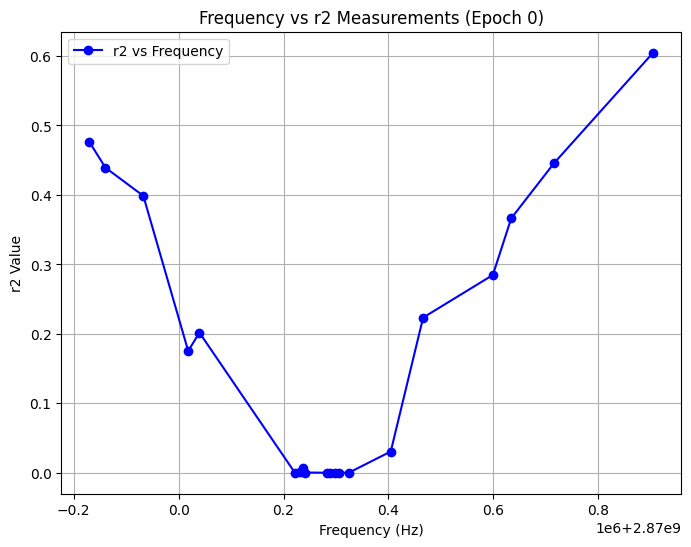

In [ ]:
import matplotlib.pyplot as plt

# Assuming epoch0 contains [frequency_shifted, r2_measured_shifted] pairs for epoch 0
# Example format: epoch0 = [[frequency1, r2_1], [frequency2, r2_2], ...]

# Extract frequencies and r2 measurements from epoch0
frequencies = [pair[0] for pair in epoch0]
r2_values = [pair[1] for pair in epoch0]

# Sort the frequencies and corresponding r2 values for a smoother plot
sorted_indices = sorted(range(len(frequencies)), key=lambda x: frequencies[x])
sorted_frequencies = [frequencies[i] for i in sorted_indices]
sorted_r2_values = [r2_values[i] for i in sorted_indices]

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(sorted_frequencies, sorted_r2_values, marker='o', linestyle='-', color='b', label='r2 vs Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('r2 Value')
plt.title('Frequency vs r2 Measurements (Epoch 0)')
plt.grid(True)
plt.legend()
plt.show()


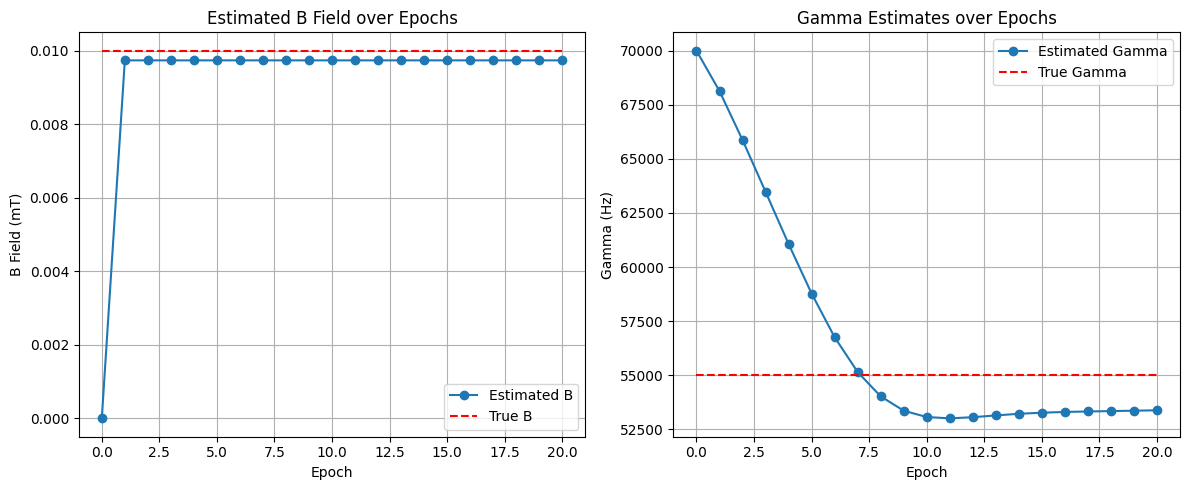

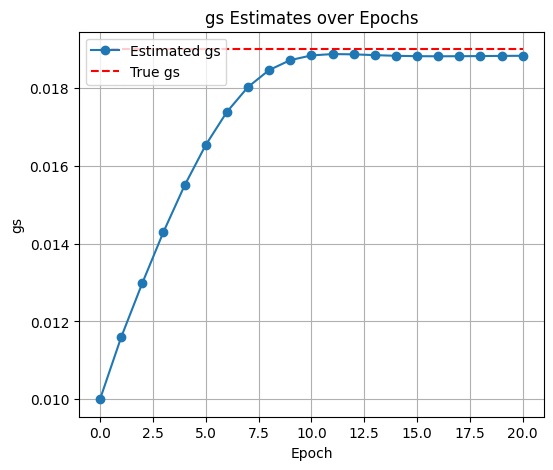

In [ ]:
# --- Plotting Estimated B Field vs. Epochs ---
epochs = np.arange(0, num_epochs + 1)  # Include initial epoch (0)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, np.array(B_estimates_over_epochs) * 1e3, marker='o', label='Estimated B')
plt.hlines(y=B_field_true * 1e3, xmin=0, xmax=num_epochs, colors='r', linestyles='dashed', label='True B')
plt.xlabel('Epoch')
plt.ylabel('B Field (mT)')
plt.title('Estimated B Field over Epochs')
plt.legend()
plt.grid(True)

# --- Plotting Estimated Parameters over Epochs ---
# Plot gamma estimates
plt.subplot(1, 2, 2)
plt.plot(epochs, gamma_estimates_over_epochs, marker='o', label='Estimated Gamma')
plt.hlines(y=gamma_true, xmin=0, xmax=num_epochs, colors='r', linestyles='dashed', label='True Gamma')
plt.xlabel('Epoch')
plt.ylabel('Gamma (Hz)')
plt.title('Gamma Estimates over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Plot gs Estimates over Epochs ---
plt.figure(figsize=(6, 5))
plt.plot(epochs, gs_estimates_over_epochs, marker='o', label='Estimated gs')
plt.hlines(y=gs_true, xmin=0, xmax=num_epochs, colors='r', linestyles='dashed', label='True gs')
plt.xlabel('Epoch')
plt.ylabel('gs')
plt.title('gs Estimates over Epochs')
plt.legend()
plt.grid(True)
plt.show()
